**REPORT FROM:**

*   **MANSOURI ZACHARIA**
*   **OZTURK SAKIR**

# Fetch Data
**In this phase we fetch the data from a local database file and load the tables in different variables.**


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
dat = sqlite3.connect('drive/My Drive/database.sqlite')

Loading X_train table

In [0]:
query_str = "SELECT * FROM X_train"
query = dat.execute(query_str)
cols = [column[0] for column in query.description]
X_train_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

Loading Team_Attributes table

In [0]:
query_str = "SELECT * FROM Team_Attributes"
query = dat.execute(query_str)
cols = [column[0] for column in query.description]
team_attribute_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

Loading Player_Attributes table

In [0]:
query_str = "SELECT * FROM Player_Attributes"
query = dat.execute(query_str)
cols = [column[0] for column in query.description]
player_attribute_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

# Clean & Export Data
**In this phase we use simple vizualisation techniques like data.info() to gain some basic insight about our data and then  we use histograms, correlation matrices and scatter plots. That way, we choose how to clean the data. After that, we merge the data coming from the different tables and then create a dataset exported into a csv file.**

Removed all the Nans

In [0]:
for df, name in zip([X_train_df, team_attribute_df, player_attribute_df], ["X_train", "team_attribute", "player_attribute"]):
  df_int64 = [df.columns[i] for i in range(len(df.columns)) if np.issubdtype(df.dtypes[i], np.int64)]
  df_float64 = [df.columns[i] for i in range(len(df.columns)) if np.issubdtype(df.dtypes[i], np.float64)]
  df_object = [df.columns[i] for i in range(len(df.columns)) if np.issubdtype(df.dtypes[i], np.object) and not np.issubdtype(df.dtypes[i], np.int64) and not np.issubdtype(df.dtypes[i], np.float64)] # needed because all np objects are considered as objects
  print("All the types of " + name + " are in (int64, float64, object):", len(df_int64) + len(df_float64) + len(df_object) == len(df.columns))

  df[df_int64] = df[df_int64].fillna(0)
  df[df_float64] = df[df_float64].fillna(0)
  df['date'] = pd.to_datetime(df['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Conversion of the second argument of issubdtype from `object` to `np.generic` is deprecated. In future, it will be treated as `np.object_ == np.dtype(object).type`.
  after removing the cwd from sys.path.


All the types of X_train are in (int64, float64, object): True
All the types of team_attribute are in (int64, float64, object): True
All the types of player_attribute are in (int64, float64, object): True


## Creating and exporting the entire dataset

In [0]:
def create_label(row):
  """
  Method that creates the label of a row
  Input : row = row of the DataFrame
  Output : 1 if the home team wins, -1 if the home team loses , 0 if tie game
  """
  return 1 if row['home_team_goal'] > row['away_team_goal'] else -1 if row['home_team_goal'] < row['away_team_goal'] else 0

In [0]:
team_attr_cols = ['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
             'buildUpPlayDribbling', 'buildUpPlayDribblingClass', 'buildUpPlayPassing', 'buildUpPlayPassingClass',
             'buildUpPlayPositioningClass', 'chanceCreationPassing', 'chanceCreationPassingClass', 'chanceCreationCrossing',
             'chanceCreationCrossingClass', 'chanceCreationShooting', 'chanceCreationShootingClass', 'chanceCreationPositioningClass',
             'defencePressure', 'defencePressureClass', 'defenceAggression', 'defenceAggressionClass', 'defenceTeamWidth', 
             'defenceTeamWidthClass', 'defenceDefenderLineClass']

def load_team_attributes(is_training_data):
  """
  Method that loads all the team attributes of a match
  input : is_training_data = boolean (if true ==> training_data)
  output : DataFrame with all the attributes of the home team and away team of each match
  """
  table_name = "X_train" if is_training_data else "X_test"
  left_joins = ""
  left_joins += "LEFT JOIN Team_Attributes home ON {}.home_team_api_id = home.team_api_id AND home.date <= {}.date ".format(table_name, table_name)
  left_joins += "LEFT JOIN Team_Attributes away ON {}.away_team_api_id = away.team_api_id  AND away.date <= {}.date ".format(table_name, table_name)
  all_cols = ["{}.id".format(table_name)]
  if is_training_data: #if it's the training data, get the goald aswell
    all_cols.append("{}.home_team_goal".format(table_name))
    all_cols.append("{}.away_team_goal".format(table_name))

  for col in team_attr_cols:
    new_col_name_home = "home.{} as {}_home".format(col, col)
    new_col_name_away = "away.{} as {}_away".format(col, col)
    all_cols.append(new_col_name_home)
    all_cols.append(new_col_name_away)

  query_str = "SELECT {} FROM {} {} GROUP BY {}.id ORDER BY {}.id".format(",".join(all_cols), table_name ,left_joins, table_name, table_name)
  query = dat.execute(query_str)
  cols = [column[0] for column in query.description]
  team_attr = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
  return team_attr



In [0]:
player_attr_cols = ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential', 'preferred_foot',
                    'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing',
                     'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration'
                     , 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots'
                     , 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
                     'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

def load_player_attributes(player, is_training_data):
  """
  Method that loads all the attributes of a player for each match
  input : player = player of the match
          is_training_data = boolean (if true ==> training_data)
  output : DataFrame with all the attributes of the home team and away team of each match
  """
  table_name = "X_train" if is_training_data else "X_test"
  left_joins = "LEFT JOIN Player_Attributes {} ON {}.{} = {}.player_api_id AND {}.date <= {}.date ".format(player, table_name, player, player, player, table_name)
  all_cols = []
  for col in player_attr_cols:
      new_col_name = "{}.{} as {}_{}".format(player, col, col, player)
      all_cols.append(new_col_name)

  query_str = "SELECT {} FROM {} {} GROUP BY {}.id ORDER BY {}.id".format(",".join(all_cols), table_name, left_joins, table_name, table_name)
  query = dat.execute(query_str)
  cols = [column[0] for column in query.description]
  player_attr = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
  return  player_attr

In [0]:
import time
TRAINING_DATA_NAME = 'drive/My Drive/training_data.csv'
TESTING_DATA_NAME = 'drive/My Drive/test_data_test.csv'
all_players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
def load_or_create_data(is_training_data, file_name):
  starting_time = time.time()
  try:
    data =  pd.read_csv(file_name)
    print("Data file named {} found".format(file_name))
    print("Data loaded in {} seconds".format(time.time()-starting_time ))
  except:
    print("No data file named {} found, new data will be created".format(file_name))
    data = load_team_attributes(is_training_data)
    print("Team attributes loaded")
    for player in all_players:
      data = pd.concat([data, load_player_attributes(player, is_training_data)], axis = 1)
      print("{} loaded".format(player))
    if(is_training_data): #put label if training_data
      data['label'] = data.apply( lambda row: create_label(row), axis=1)
      data.drop(columns = ["home_team_goal", "away_team_goal"], inplace=True) #useless now
      print("Creating label done")
    for col in data.columns:#clean the data
      dtype = data.dtypes[col]
      if dtype == 'object' :
        data[col] = data[col].fillna('Unknown')
      elif dtype == 'int64' or dtype == 'float64' :
        data[col] = data[col].fillna(0)
        
    print("Writing the data in {}".format(file_name))
    data.to_csv(file_name)
    print("Data processed in {} seconds".format(time.time()-starting_time ))
  return data

In [0]:
training_data = load_or_create_data(is_training_data = True, file_name = TRAINING_DATA_NAME)
print(training_data.info())

Data file named drive/My Drive/training_data.csv found
Data loaded in 3.0454816818237305 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Columns: 977 entries, Unnamed: 0 to label
dtypes: float64(860), int64(3), object(114)
memory usage: 152.6+ MB
None


In [0]:
test_data = load_or_create_data(is_training_data = False, file_name = TESTING_DATA_NAME)
print(test_data.info())

Data file named drive/My Drive/test_data_test.csv found
Data loaded in 0.9917697906494141 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Columns: 976 entries, Unnamed: 0 to gk_reflexes_away_player_11
dtypes: float64(860), int64(2), object(114)
memory usage: 41.0+ MB
None


## Data Analyzes

### X_train

In [0]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Data columns (total 78 columns):
index               20479 non-null int64
id                  20479 non-null int64
country_id          20479 non-null int64
league_id           20479 non-null int64
season              20479 non-null object
stage               20479 non-null int64
date                20479 non-null datetime64[ns]
match_api_id        20479 non-null int64
home_team_api_id    20479 non-null int64
away_team_api_id    20479 non-null int64
home_team_goal      20479 non-null int64
away_team_goal      20479 non-null int64
home_player_X1      20479 non-null float64
home_player_X2      20479 non-null float64
home_player_X3      20479 non-null float64
home_player_X4      20479 non-null float64
home_player_X5      20479 non-null float64
home_player_X6      20479 non-null float64
home_player_X7      20479 non-null float64
home_player_X8      20479 non-null float64
home_player_X9      20479 non-null float64
ho

The columns have around 1000 null values. That represents less than 5% of the total number of the entries in dataset. 5% can be considered as nearly negligible, therefore we fill those values with 0s.

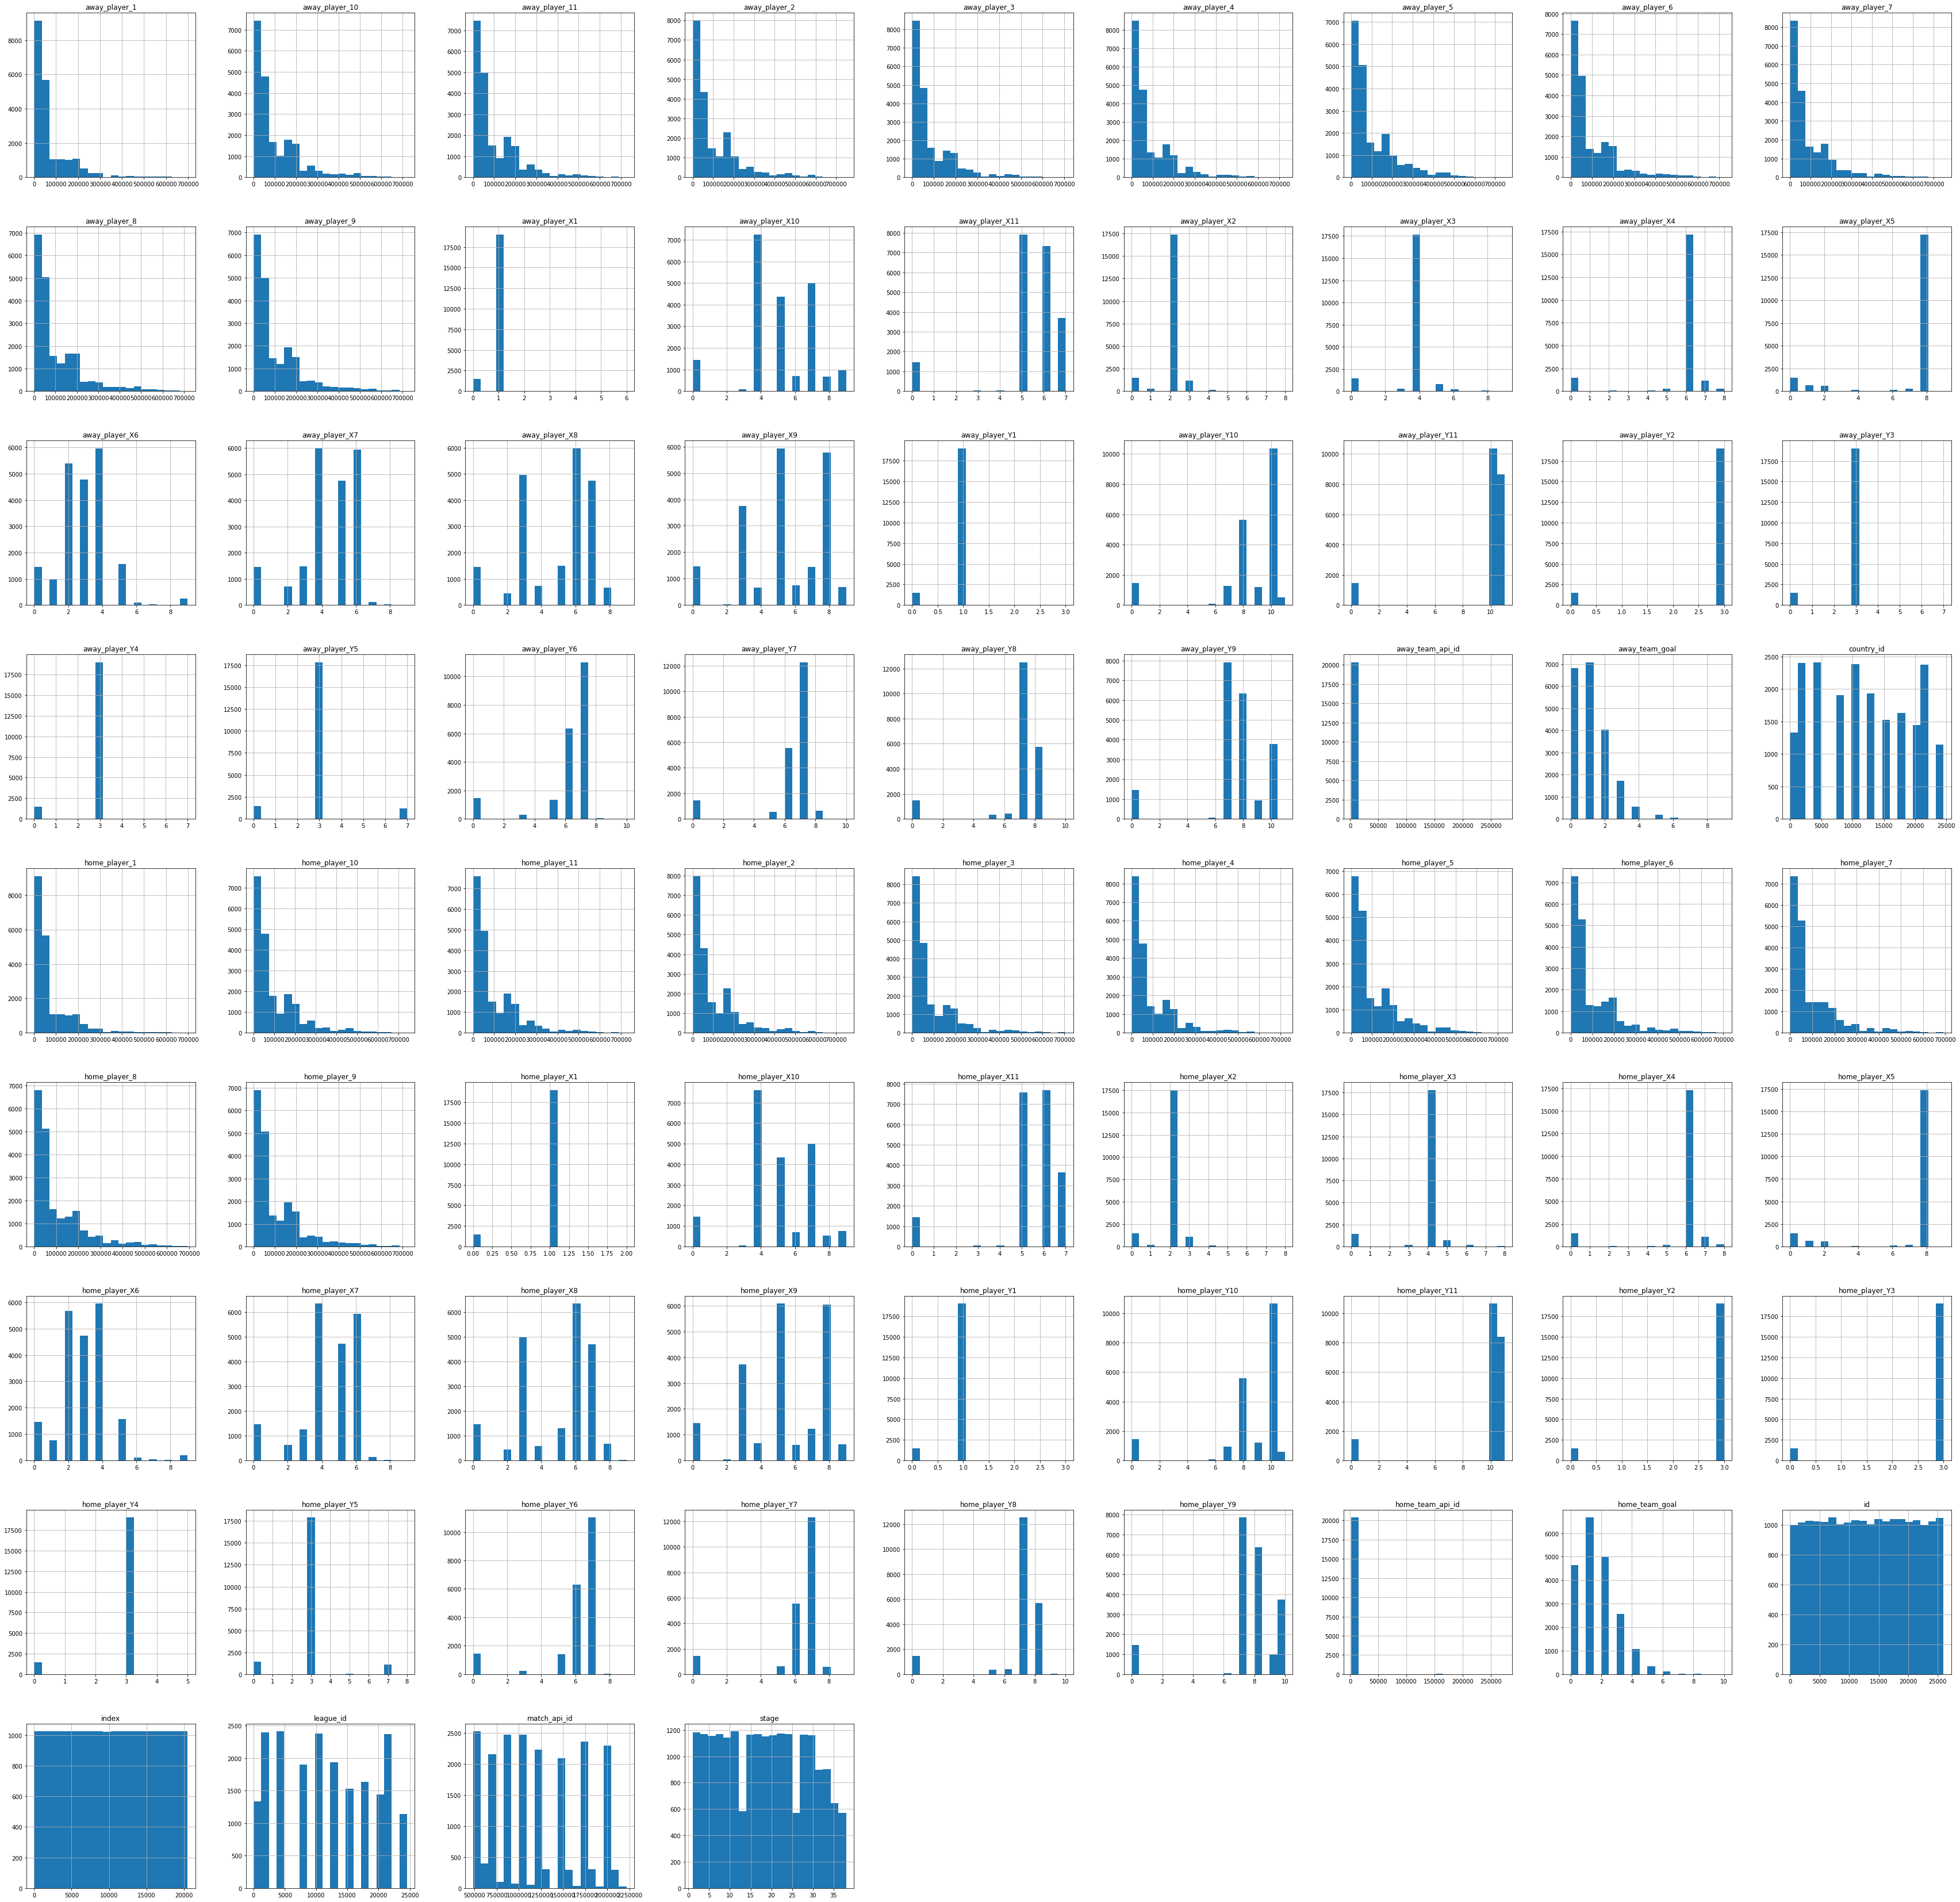

In [0]:
hist = X_train_df.hist(figsize=(60, 60), bins=20)

We see on these histograms that the 0 values are visually present and sometimes play the role of outliers. But like we've said, it's not a big problem. Note that the coordinates (X, Y) of this table will not be used because the're the ones that seem to have the more 0s as outliers. Also, we'll use the players' attributes that already model the coordinates stragegy because in reality, the players are placed depending on their attributes.

In [0]:
corr = X_train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

We can see that country_id and league_id are highly correlated to id. We will delete those columns. Also, most of the big correlations are between the players' coordinates. We already choose not to take those columns into our final dataset, meaning that we don't care about those correlations here.

### Team_Attributes

In [0]:
team_attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
id                                1458 non-null int64
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null datetime64[ns]
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              1458 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreati

The only column that has null entries is the "buildUpPlayDribbling" columns. Around 66% of its values are null.
Therefore we will delete the column "buildUpPlayDribbling".

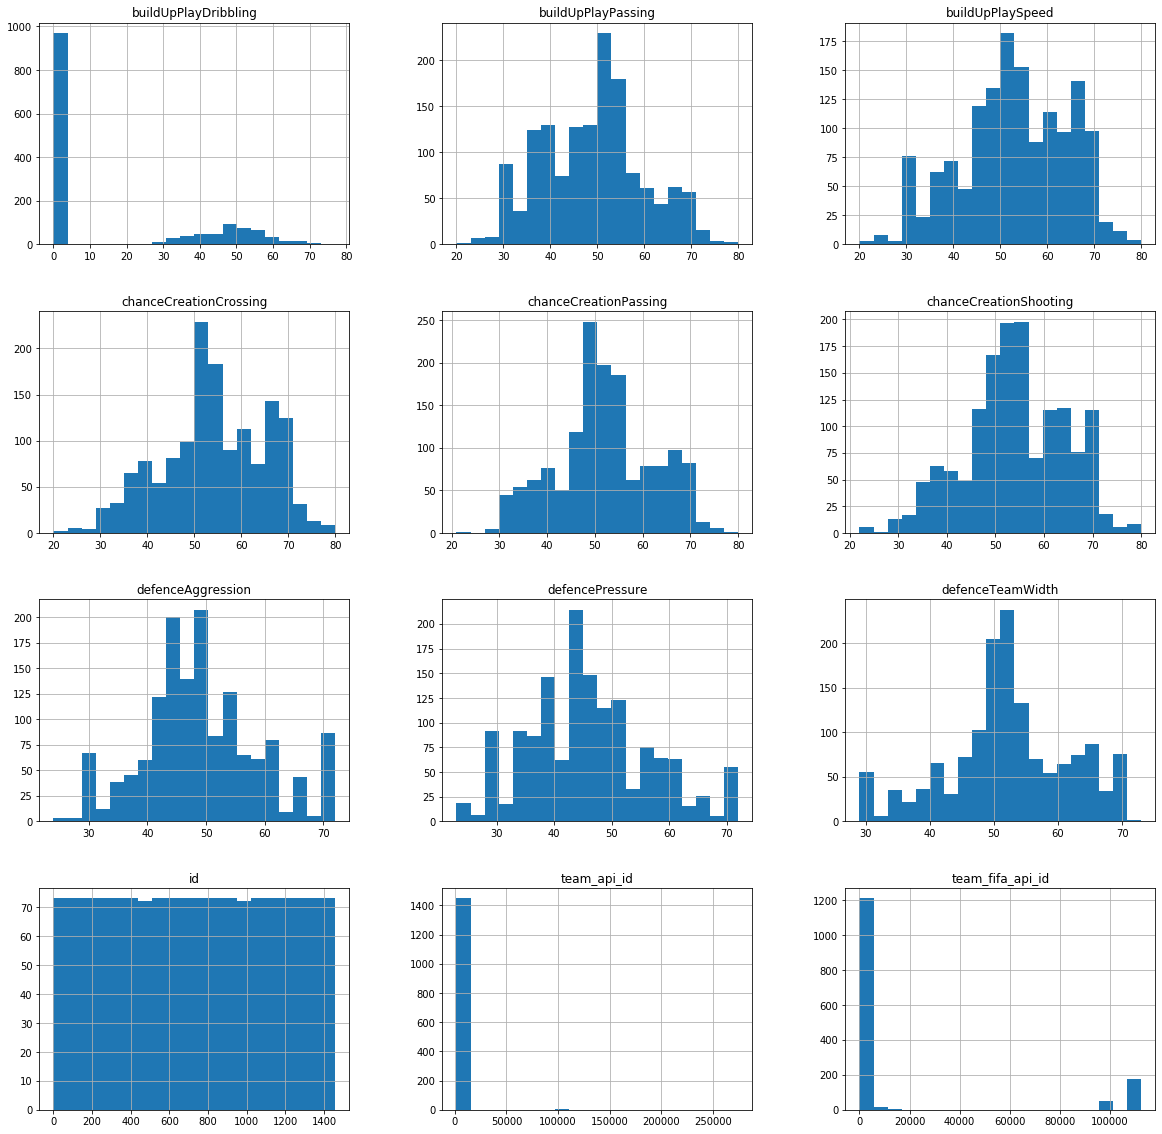

In [0]:
hist = team_attribute_df.hist(figsize=(20, 20), bins=20)

The column "buildUpPlayDribbling" has in fact too many 0s to be taken in our dataset. That proves that we'll have to drop it from the final dataset.

In [0]:
corr = team_attribute_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
id,1,-0.0104987,-0.089566,-0.029374,-0.00420684,-0.0190563,0.0179205,0.020098,-0.0204465,-0.0134499,-0.0522194,-0.0475609
team_fifa_api_id,-0.0104987,1,0.164102,-0.0173633,0.0427821,0.00768254,-0.0257133,-0.108358,0.00299332,-0.0597598,0.00052243,-0.071675
team_api_id,-0.089566,0.164102,1,0.0043366,0.076391,0.00141549,-0.00522753,-0.0655535,-0.0727107,-0.0649012,-0.0309053,-0.0711608
buildUpPlaySpeed,-0.029374,-0.0173633,0.0043366,1,0.105848,0.395506,0.319162,0.191687,0.0720977,0.0463972,0.160569,0.0670193
buildUpPlayDribbling,-0.00420684,0.0427821,0.076391,0.105848,1,0.0398854,0.038471,-0.032883,-0.160077,-0.0550377,-0.0579044,-0.0321189
buildUpPlayPassing,-0.0190563,0.00768254,0.00141549,0.395506,0.0398854,1,0.220367,0.231088,-0.077325,-0.0504871,0.122451,0.0631501
chanceCreationPassing,0.0179205,-0.0257133,-0.00522753,0.319162,0.038471,0.220367,1,0.246528,0.112497,0.203158,0.145212,0.150143
chanceCreationCrossing,0.020098,-0.108358,-0.0655535,0.191687,-0.032883,0.231088,0.246528,1,-0.0125764,0.0871081,0.0988739,0.131515
chanceCreationShooting,-0.0204465,0.00299332,-0.0727107,0.0720977,-0.160077,-0.077325,0.112497,-0.0125764,1,0.185603,0.116578,0.129166
defencePressure,-0.0134499,-0.0597598,-0.0649012,0.0463972,-0.0550377,-0.0504871,0.203158,0.0871081,0.185603,1,0.422493,0.508464


Most of the correlations are weak. The defence characteristics have the stronger correlations but they're not strong enough to make us replace all the defence characteristics by only one defence characteristic.


### Player_Attributes

In [0]:
player_attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null datetime64[ns]
overall_rating         183978 non-null float64
potential              183978 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183978 non-null float64
finishing              183978 non-null float64
heading_accuracy       183978 non-null float64
short_passing          183978 non-null float64
volleys                183978 non-null float64
dribbling              183978 non-null float64
curve                  183978 non-null float64
free_kick_accuracy     183978 non-null float64
long_passing           183978 non-null float64
ball_control           183978 non-null float6

The columns all have less that 1000 null values. The total number of entries being around 183000, we'll consider the amount of null values is negligible for each of the columns.

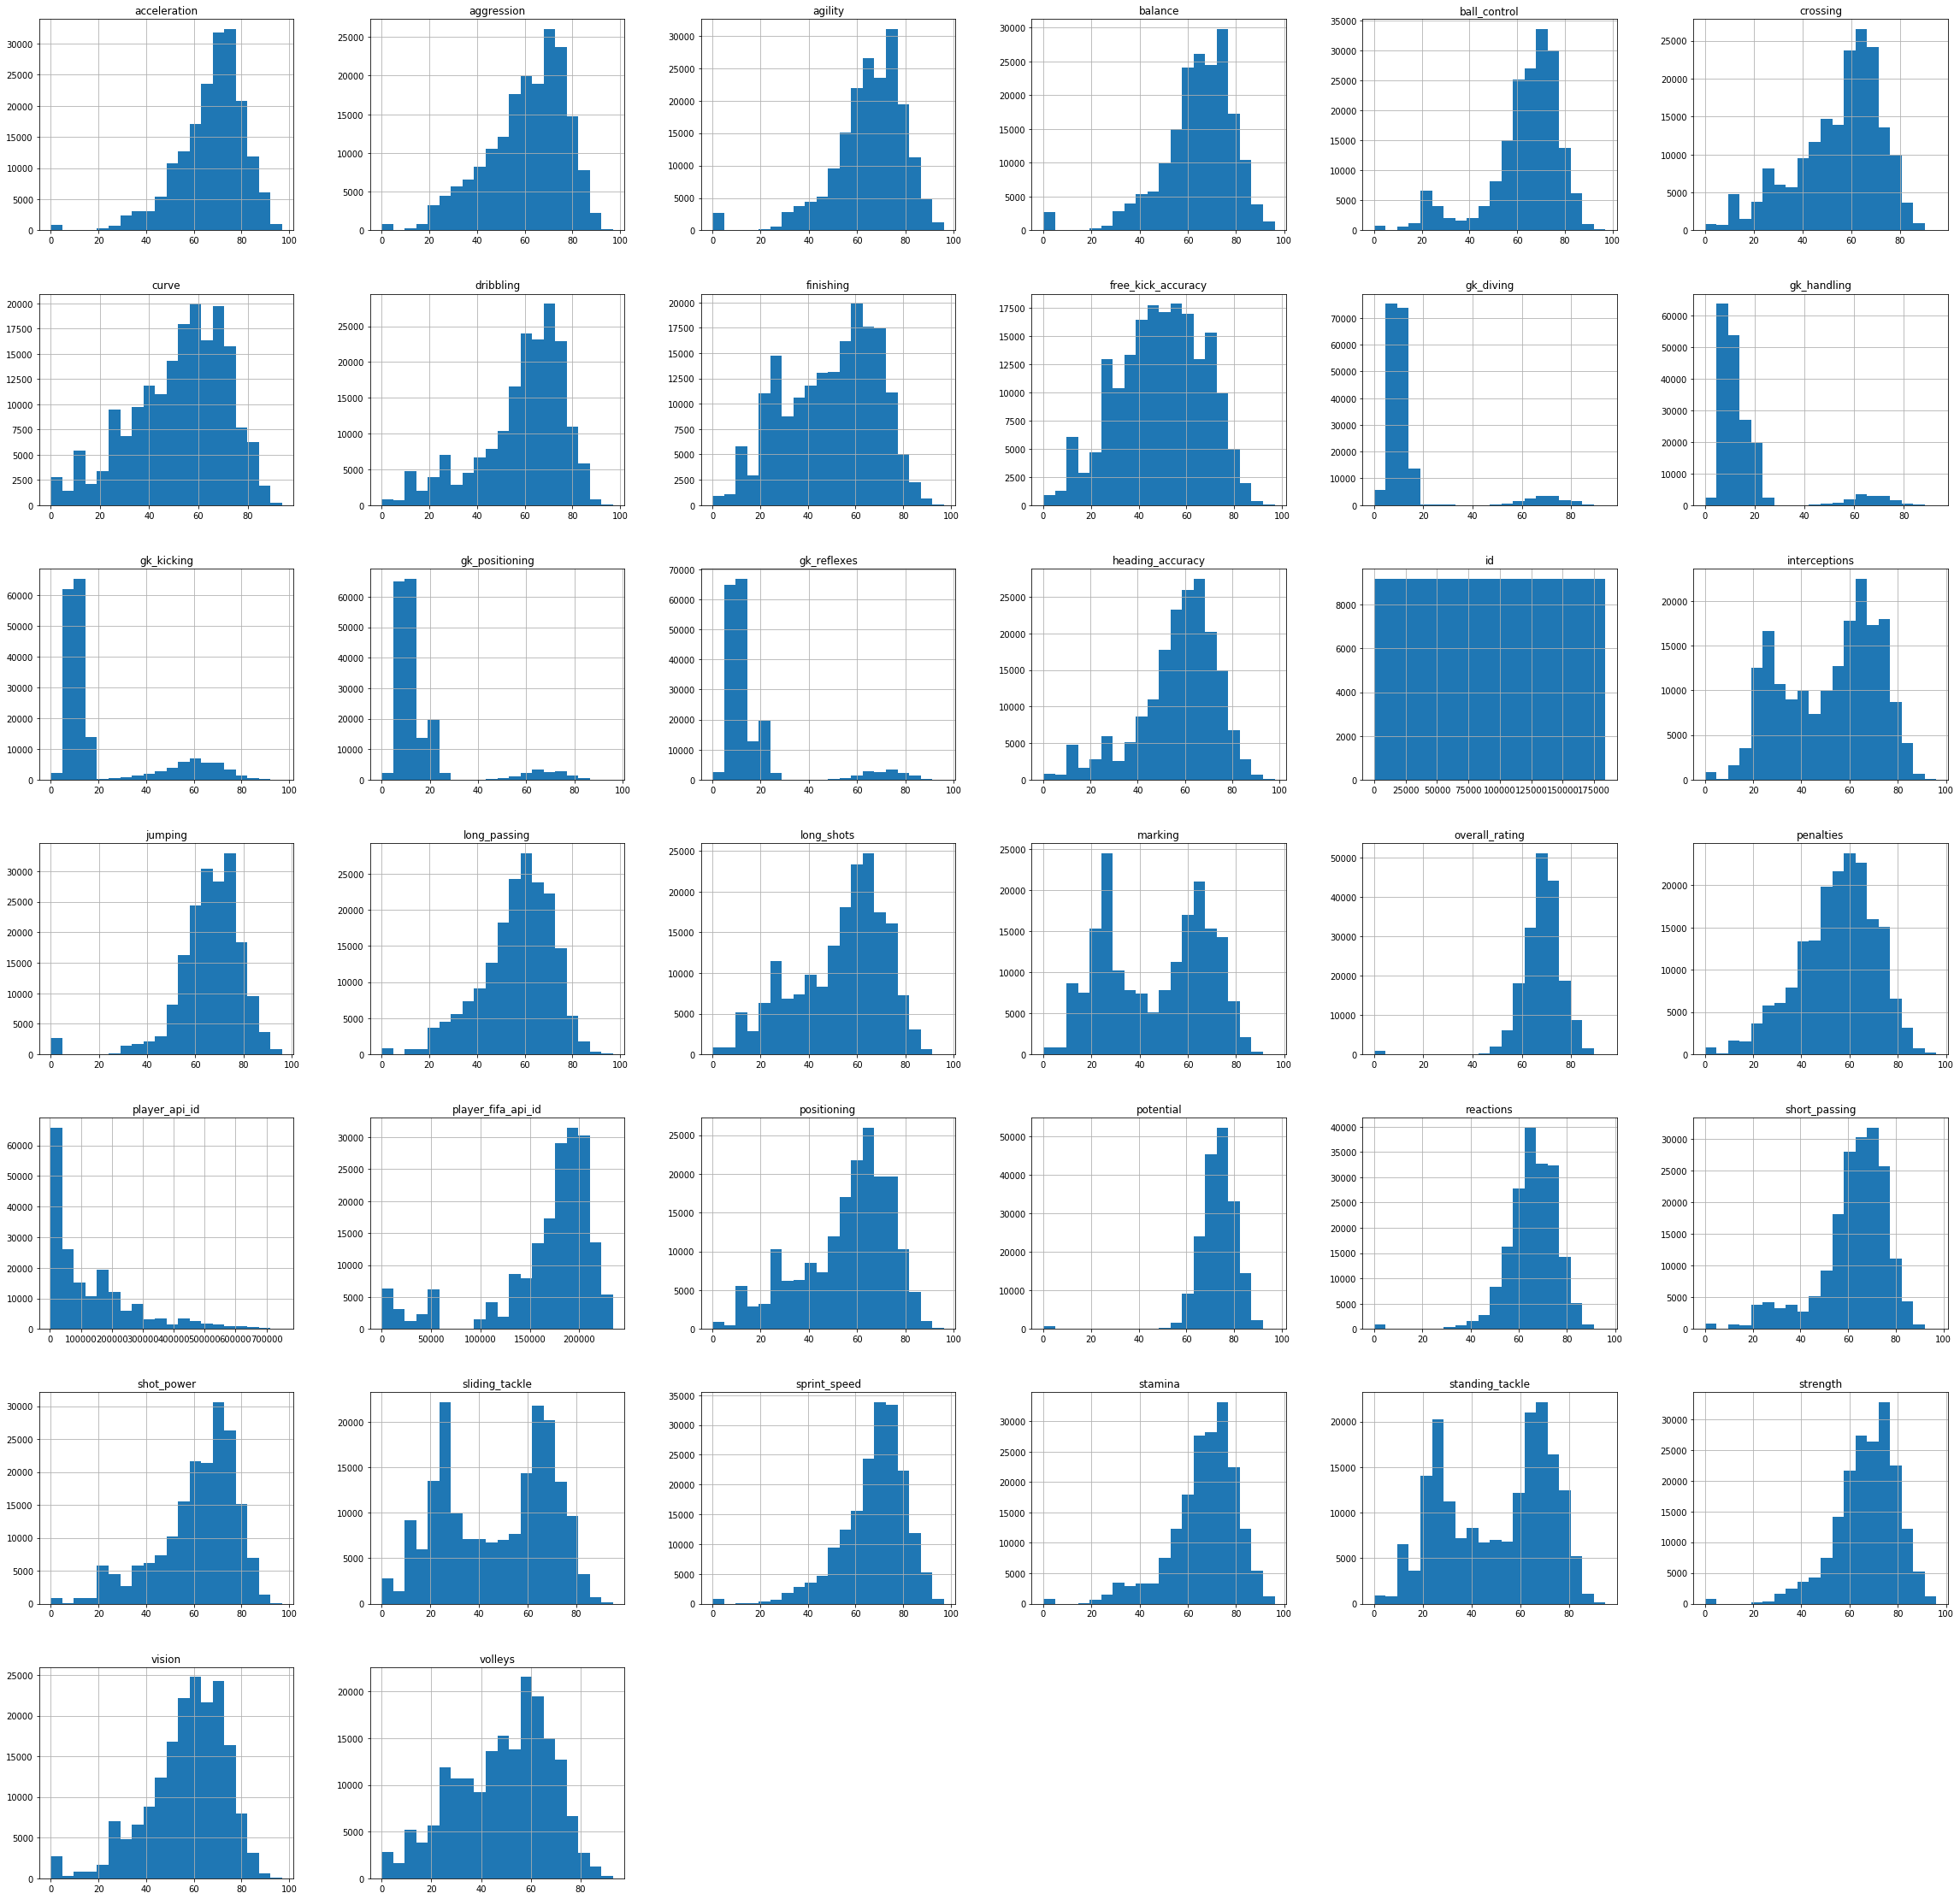

In [0]:
hist = player_attribute_df.hist(figsize=(40, 40), bins=20)

Outliers are negligible, like we've seen when looking for the null values.

In [0]:
corr = player_attribute_df.corr()
corr.style.background_gradient(cmap='coolwarm')

We see that most of the attributes are quite correlated. The players' attributes (on the terrain, not in the goal) are correlated between themselves and the goal keepers' attributes are correlated between themselves. The player's attributes can be approximated by the overall rating and, intuitively, that capacity of a player to play as a goal keeper does not affect that much his value as a player. Therefore, we'll only keep the overall rating.

We also wanted to compare the overall ratings of all the players in the home team with overall ratings of all the players in the away team:

In [0]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Columns: 977 entries, Unnamed: 0 to label
dtypes: float64(860), int64(3), object(114)
memory usage: 152.6+ MB


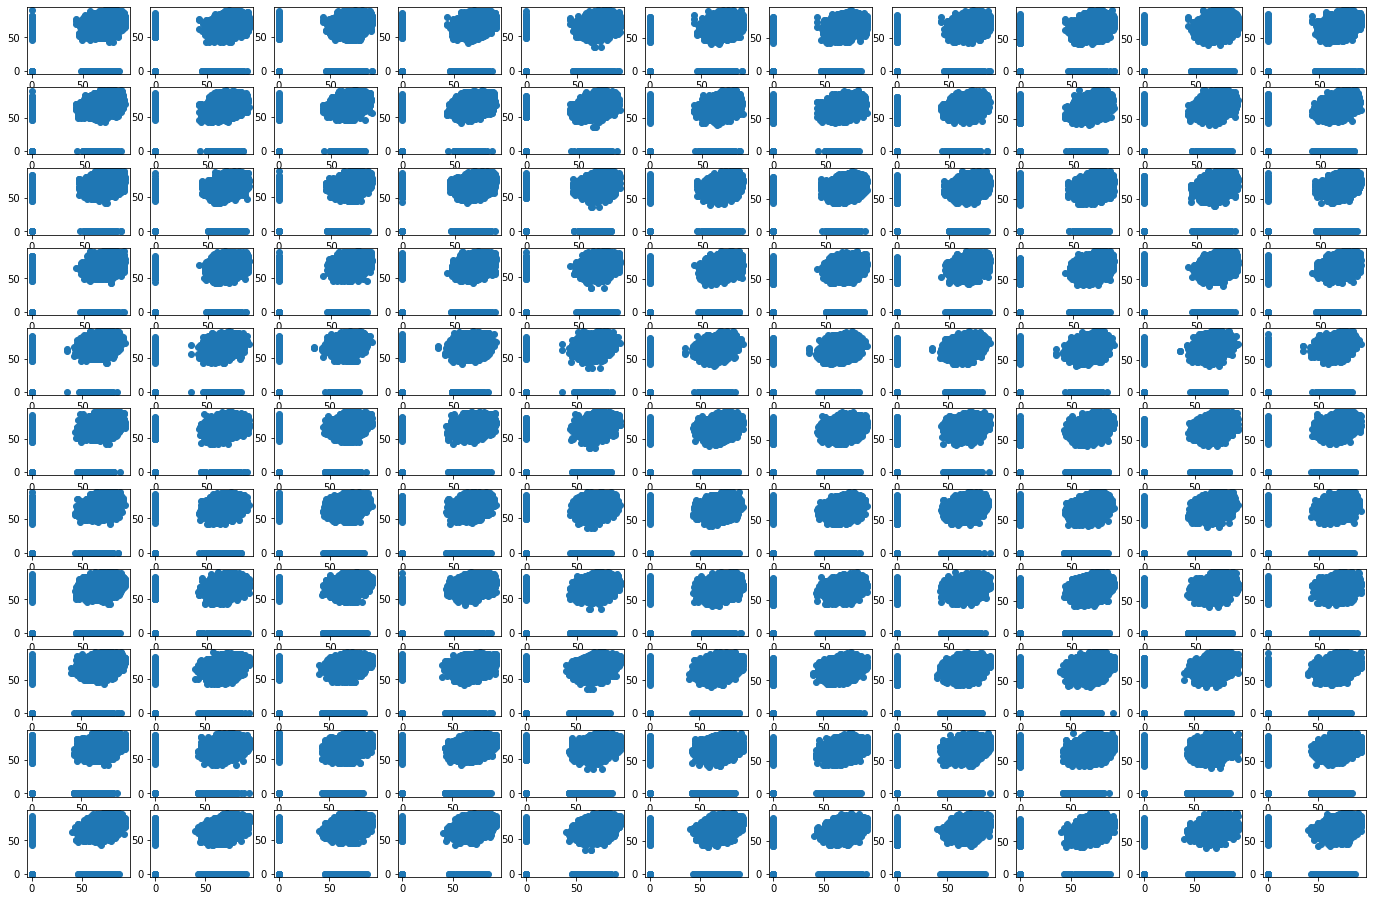

In [0]:
xsize, ysize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (24, 16)

fig, axs = plt.subplots(11, 11)
for i in range(1, 12):
  for j in range(1, 12):
    axs[i - 1, j - 1].scatter(training_data["overall_rating_home_player_" + str(i)], training_data["overall_rating_away_player_" + str(j)])
plt.show()

plt.rcParams["figure.figsize"] = (xsize, ysize)

We can see that there are lots of ratings equals to zero in most for most of the comparisons. There are maybe lines in the table where there are lots of 0s. Let's check that and drop the lines from the training data where there are 11 (value of nb_to_drop below) or more players that do not have an overall rating (theirs is equal to 0). We choosed nb_to_drop = 11 because that would mean that we don't have this information for the equivalent of a full team.

In [0]:
cols = ["overall_rating_home_player_" + str(i) for i in range(1, 12)]
cols.extend(["overall_rating_away_player_" + str(i) for i in range(1, 12)])

lines = training_data[cols]
total = len(lines)
counts = [0]*len(lines)
for i in range(len(lines)):
  if i % 1000 == 0:
    print("[{}/{}]".format(i, total))
  for col in cols:
    if (lines.iloc(0)[i][col]) == 0:
      counts[i] += 1
print("[{}/{}]".format(total, total))
nb_to_drop = 11
indexes_to_del = [i for i in range(len(counts)) if counts[i] >= nb_to_drop]
training_data = training_data.drop(indexes_to_del)
print("{} lines with {} or more unknown overall ratings dropped from the training data set".format(len(indexes_to_del), nb_to_drop))

[0/20479]
[1000/20479]
[2000/20479]
[3000/20479]
[4000/20479]
[5000/20479]
[6000/20479]
[7000/20479]
[8000/20479]
[9000/20479]
[10000/20479]
[11000/20479]
[12000/20479]
[13000/20479]
[14000/20479]
[15000/20479]
[16000/20479]
[17000/20479]
[18000/20479]
[19000/20479]
[20000/20479]
[20479/20479]
851 lines with 11 or more unknown overall ratings dropped from the training data set


Let's see if that cleaned the comparisons between the overall ratings of the home players and away players:

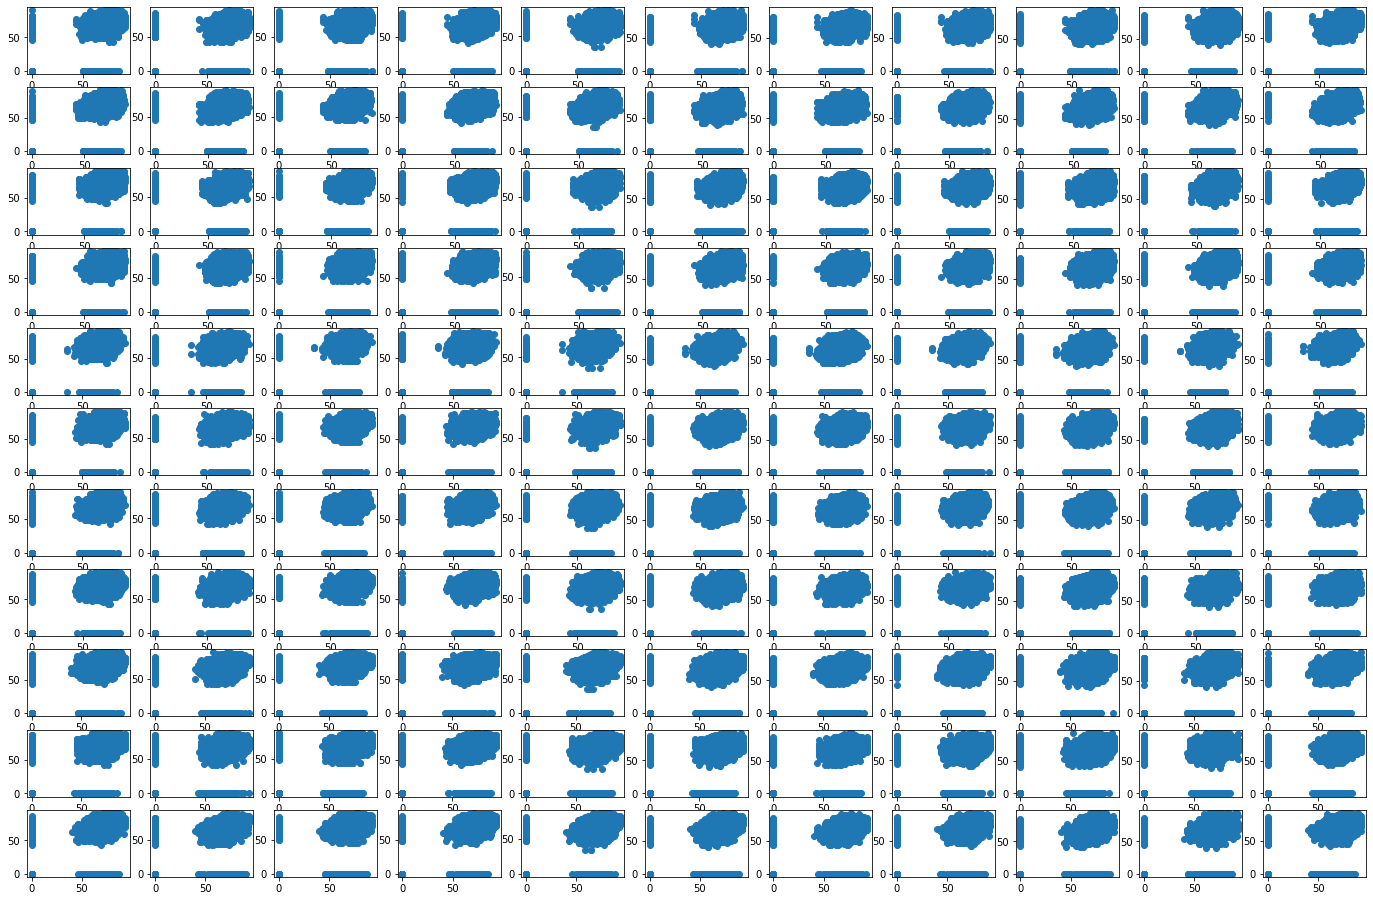

In [0]:
xsize, ysize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (24, 16)

fig, axs = plt.subplots(11, 11)
for i in range(1, 12):
  for j in range(1, 12):
    axs[i - 1, j - 1].scatter(training_data["overall_rating_home_player_" + str(i)], training_data["overall_rating_away_player_" + str(j)])
plt.show()

plt.rcParams["figure.figsize"] = (xsize, ysize)

The difference may not be appearing clearly because there are only 851 lines that have been deleted. However, if you set the nb_to_drop variable in the code above to a way smaller value (ex: 2) you'll clearly see the difference. We didn't set this variable to 2 here because it would drop around 1000 more lines, which would start to reduce the size of the training set. Therefore, we choosed to change all the O values to nan values and apply the mean to each of the nan values for all the overall ratings.

In [0]:
overall_rating_cols = ["overall_rating_home_player_" + str(i) for i in range(1, 12)]
overall_rating_cols.extend(["overall_rating_away_player_" + str(i) for i in range(1, 12)])
training_data[overall_rating_cols] = training_data[overall_rating_cols].replace(0, np.nan)
training_data[overall_rating_cols] = training_data[overall_rating_cols].apply(lambda x: x.fillna(x.mean()), axis=1)
training_data[overall_rating_cols]

,overall_rating_home_player_1,overall_rating_home_player_2,overall_rating_home_player_3,overall_rating_home_player_4,overall_rating_home_player_5,overall_rating_home_player_6,overall_rating_home_player_7,overall_rating_home_player_8,overall_rating_home_player_9,overall_rating_home_player_10,overall_rating_home_player_11,overall_rating_away_player_1,overall_rating_away_player_2,overall_rating_away_player_3,overall_rating_away_player_4,overall_rating_away_player_5,overall_rating_away_player_6,overall_rating_away_player_7,overall_rating_away_player_8,overall_rating_away_player_9,overall_rating_away_player_10,overall_rating_away_player_11
118,70.000000,63.315789,63.315789,67.0,64.0,59.000000,61.0,63.315789,66.000000,68.00,60.0,68.000000,62.0,63.0,59.000000,56.000000,62.0,61.0,68.0,64.0,62.0,63.0
119,68.571429,74.000000,75.000000,65.0,71.0,64.000000,71.0,76.000000,75.000000,71.00,74.0,64.000000,64.0,63.0,63.000000,66.000000,72.0,68.0,67.0,62.0,67.0,68.0
120,68.000000,66.000000,60.000000,59.0,62.0,68.000000,63.0,58.000000,65.000000,65.55,69.0,66.000000,69.0,64.0,67.000000,65.550000,69.0,64.0,69.0,71.0,66.0,68.0
121,62.000000,64.000000,63.000000,62.0,59.0,63.000000,59.0,60.000000,60.368421,53.00,59.0,61.000000,56.0,59.0,60.368421,60.368421,64.0,66.0,54.0,63.0,65.0,55.0
122,68.000000,62.000000,63.000000,50.0,59.0,66.368421,61.0,62.000000,66.368421,62.00,68.0,66.368421,75.0,64.0,65.000000,71.000000,71.0,76.0,75.0,64.0,71.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20474,66.000000,63.000000,64.000000,70.0,63.0,63.000000,67.0,65.000000,55.000000,67.00,70.0,62.380952,64.0,53.0,62.000000,62.000000,60.0,54.0,65.0,59.0,57.0,61.0
20475,62.000000,52.000000,63.000000,60.0,65.0,59.000000,65.0,62.000000,64.000000,66.00,59.0,56.000000,52.0,63.0,58.000000,65.000000,63.0,65.0,65.0,64.0,60.0,67.0
20476,62.000000,57.000000,62.000000,58.0,58.0,62.000000,62.0,60.000000,66.000000,54.00,57.0,61.000000,59.0,64.0,64.000000,68.000000,51.0,59.0,65.0,65.0,68.0,70.0
20477,65.000000,59.000000,62.000000,68.0,62.0,75.000000,66.0,72.000000,68.000000,74.00,74.0,66.000000,67.0,66.0,73.000000,65.000000,63.0,68.0,66.0,68.0,66.0,72.0


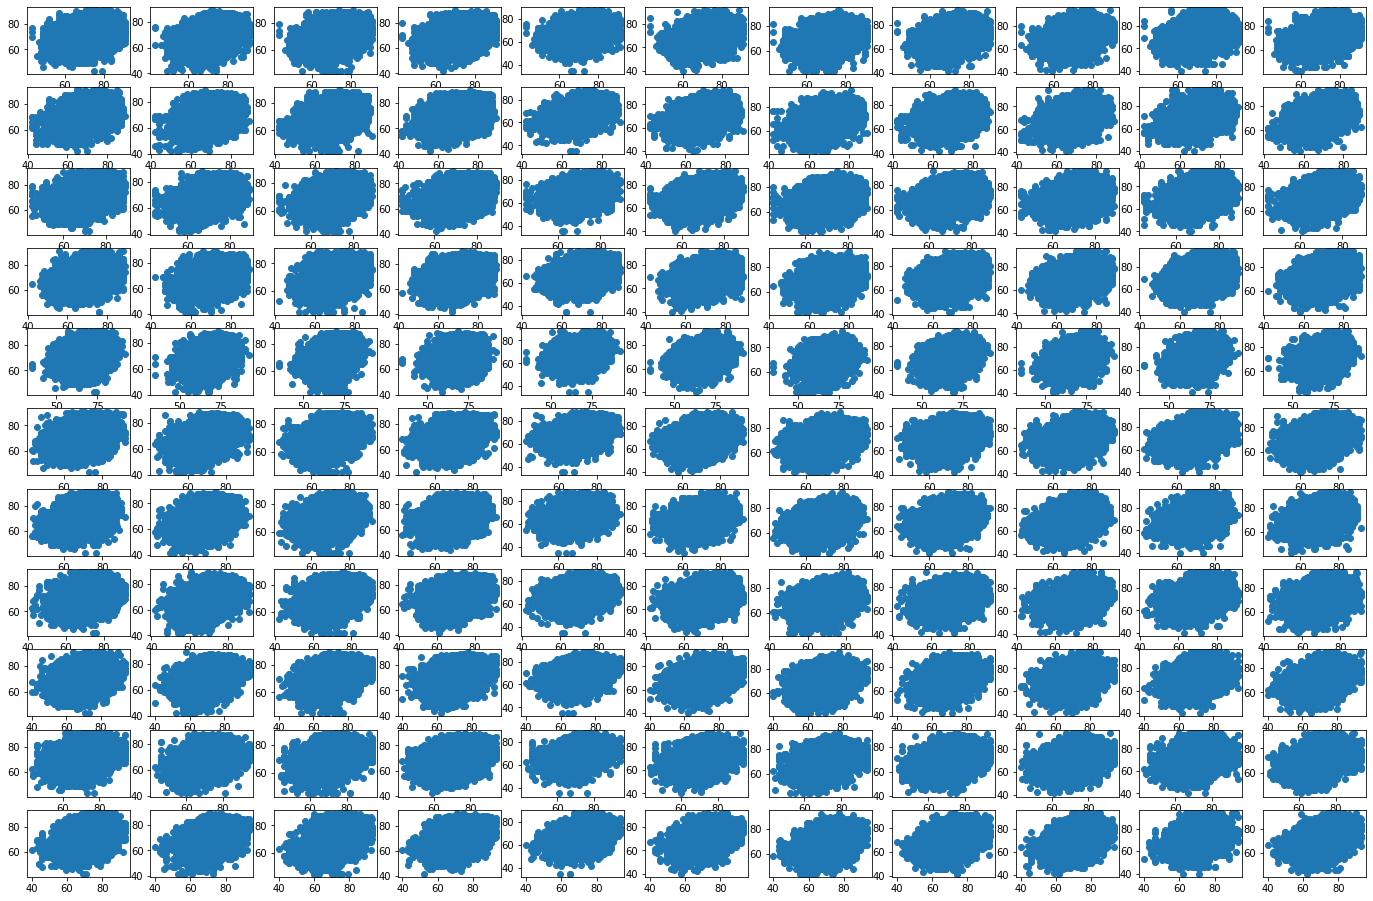

In [0]:
xsize, ysize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (24, 16)

fig, axs = plt.subplots(11, 11)
for i in range(1, 12):
  for j in range(1, 12):
    axs[i - 1, j - 1].scatter(training_data["overall_rating_home_player_" + str(i)], training_data["overall_rating_away_player_" + str(j)])
plt.show()

plt.rcParams["figure.figsize"] = (xsize, ysize)

Our first idea concerning the nan values was to replace them by 0 values because keeping nan values would sometimes cause technical when we tried to plot our data. However we've seen with the overall ratings right above that replacing them by the mean values could improve the score of our model (this model is not present in this release because it wasn't asked). We assume that doing that for all the numerical columns will globally have the same effect. For the following columns, we just put the 0 values to nan values and we'll let the imputer replace them by mean values.

In [0]:
team_attribute_columns = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']
ta_num_cols = [col + '_home' for col in team_attribute_columns]
ta_num_cols.extend([col + '_away' for col in team_attribute_columns])
training_data[ta_num_cols] = training_data[ta_num_cols].replace(0, np.nan)

We clearly see that the 0 values have been replaced by the mean.

In [0]:
def clean_data(is_training_data, nb_overall_ratings_to_drop, overall_ratings_meaned, team_attributes_meaned):
  """
  Method that loads the data (training or test) and drop the lines from the training data where there are nb_overall_ratings_to_drop
  or more players that have an overall_rating equals to 0.
  It also changes the 0 values of the overall ratings to the mean of each column if overall_ratings_meaned is True.
  It also changes the 0 values of the team attributes to NaN Values if team_attributes_meaned is True so that the imputer
  will replace them by the mean of each columns.

  Input : is_training_data = True if we are loading the training_data, False if we are loading the test_data.
          nb_overall_ratings_to_drop = Number of overall ratings that have to be equal to zero in order to drop the associated lines.
          overall_ratings_meaned = True if we want to apply the mean value to each column for the overall rating columns
          team_attributes_meaned = True if we want the imputer to apply the mean value to each column for the team attributes columns

  Output : cleaned dataset.
  """
  if is_training_data:
    data = load_or_create_data(is_training_data = True, file_name = TRAINING_DATA_NAME)

    #only removing some lines if it's the training_data
    cols = ["overall_rating_home_player_" + str(i) for i in range(1, 12)]
    cols.extend(["overall_rating_away_player_" + str(i) for i in range(1, 12)])

    lines = data[cols]
    total = len(lines)
    counts = [0]*len(lines)
    print("Deleting the lines where there are {} or more players with overall rating equal to 0".format(nb_overall_ratings_to_drop))
    for i in range(len(lines)):
      if i % 1000 == 0:
        print("[{}/{}]".format(i, total))
      for col in cols:
        if (lines.iloc(0)[i][col]) == 0:
          counts[i] += 1
    print("[{}/{}]".format(total, total))
    nb_to_drop = nb_overall_ratings_to_drop
    indexes_to_del = [i for i in range(len(counts)) if counts[i] >= nb_to_drop]
    data = data.drop(indexes_to_del)
    print("{} lines with {} or more unknown overall ratings dropped from the training data set".format(len(indexes_to_del), nb_to_drop))
  else:  
    data = load_or_create_data(is_training_data = False, file_name = TESTING_DATA_NAME)

  
  
  if overall_ratings_meaned:
    overall_rating_cols = ["overall_rating_home_player_" + str(i) for i in range(1, 12)]
    overall_rating_cols.extend(["overall_rating_away_player_" + str(i) for i in range(1, 12)])
    data[overall_rating_cols] = data[overall_rating_cols].replace(0, np.nan)
    data[overall_rating_cols] = data[overall_rating_cols].apply(lambda x: x.fillna(x.mean()), axis=1)
  
  if team_attributes_meaned:
    team_attribute_columns = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']
    ta_num_cols = [col + '_home' for col in team_attribute_columns]
    ta_num_cols.extend([col + '_away' for col in team_attribute_columns])
    data[ta_num_cols] = data[ta_num_cols].replace(0, np.nan)
  
  return data

# Prepare Data
**We apply transformations to the cleaned dataset applying one hot encoders for unordered categorical attributes, ordinal encoders for ordered categorical attributes and a standard scaler, using a pipeline.**

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class  DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
bannedList = ['Unnamed: 0','label','id_home','team_fifa_api_id_home','team_api_id_home','date_home','id_away',
              'team_fifa_api_id_away','team_api_id_away','date_away','id', 'player_fifa_api_id', 'player_api_id', 'date'
              ,'potential', 'preferred_foot', 'attacking_work_rate','defensive_work_rate',
              "gk",
              "buildUpPlayDribbling", # banned because it contains too much null values
              "sliding_tackle",
              "standing_tackle", "marking", "penalties", "vision", "positioning","interceptions",  "aggression", 
              "long_shots",  "strength", "stamina" , "jumping", "shot_power", "balance", "reactions", "agility",
              "sprint_speed", "acceleration" , "ball_control", "long_passing", "free_kick_accuracy", "curve",
              "dribbling", "volleys", "short_passing", "heading_accuracy", "finishing",  "crossing"
              ]

cat_with_order = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass' , 'chanceCreationPassingClass' , 'chanceCreationCrossingClass',  'chanceCreationShootingClass'
 'defencePressureClass', 'defenceTeamWidthClass' ]

num_attr = []
cat_attr_without_order = []
cat_attr_with_order = []
for i in range(len(training_data.columns)):
  col = training_data.columns[i]
  dtype = training_data.dtypes[col]
  banned = False
  for bannedWord in bannedList :
    if col.startswith(bannedWord):
      banned = True
      break;
  if( not banned and dtype == 'object' ):
    is_cat_with_order = False
    for cat_w_order in cat_with_order:
      if col.startswith(cat_w_order):
        cat_attr_with_order.append(col)
        is_cat_with_order = True
        break;
    if not is_cat_with_order:
      cat_attr_without_order.append(col)
  elif(not banned and ( dtype == 'int64' or dtype == 'float64' )):
    num_attr.append(col)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attr)) ,
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
cat_without_order_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr_without_order)),
        ('label_binarizer', OneHotEncoder(sparse=False))
        ])

cat_with_order_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr_with_order)),
        ('label_binarizer', OrdinalEncoder())
        ])
    
full_pipeline = FeatureUnion(transformer_list = [
        ("num_pipeline", num_pipeline),
        ("cat_without_order_pipeline", cat_without_order_pipeline),
        ("cat_with_order_pipeline", cat_with_order_pipeline),
        ])


In [0]:
for cat in num_attr :
  print(cat)
for cat in cat_attr_without_order :
  print(cat)
for cat in cat_attr_with_order :
  print(cat)

buildUpPlaySpeed_home
buildUpPlaySpeed_away
buildUpPlayPassing_home
buildUpPlayPassing_away
chanceCreationPassing_home
chanceCreationPassing_away
chanceCreationCrossing_home
chanceCreationCrossing_away
chanceCreationShooting_home
chanceCreationShooting_away
defencePressure_home
defencePressure_away
defenceAggression_home
defenceAggression_away
defenceTeamWidth_home
defenceTeamWidth_away
overall_rating_home_player_1
overall_rating_home_player_2
overall_rating_home_player_3
overall_rating_home_player_4
overall_rating_home_player_5
overall_rating_home_player_6
overall_rating_home_player_7
overall_rating_home_player_8
overall_rating_home_player_9
overall_rating_home_player_10
overall_rating_home_player_11
overall_rating_away_player_1
overall_rating_away_player_2
overall_rating_away_player_3
overall_rating_away_player_4
overall_rating_away_player_5
overall_rating_away_player_6
overall_rating_away_player_7
overall_rating_away_player_8
overall_rating_away_player_9
overall_rating_away_player_1

In [0]:
#GLOBAL PARAM FOR CLEANING THE DATA
OVERALL_RATINGS_MEANED = True
TEAM_ATTRIBUTES_MEANED = False

#Loading and cleaning training_data
training_data = clean_data(is_training_data = True,
                                  nb_overall_ratings_to_drop = 11,
                                  overall_ratings_meaned = OVERALL_RATINGS_MEANED, 
                                  team_attributes_meaned = TEAM_ATTRIBUTES_MEANED
                                  )

Data file named drive/My Drive/training_data.csv found
Data loaded in 3.09912371635437 seconds
Deleting the lines where there are 11 or more players with overall rating equal to 0
[0/20479]
[1000/20479]
[2000/20479]
[3000/20479]
[4000/20479]
[5000/20479]
[6000/20479]
[7000/20479]
[8000/20479]
[9000/20479]
[10000/20479]
[11000/20479]
[12000/20479]
[13000/20479]
[14000/20479]
[15000/20479]
[16000/20479]
[17000/20479]
[18000/20479]
[19000/20479]
[20000/20479]
[20479/20479]
851 lines with 11 or more unknown overall ratings dropped from the training data set


In [0]:
from sklearn.model_selection import train_test_split

labels = pd.DataFrame(training_data['label']) # take the label from the training set
features = pd.DataFrame(training_data.drop("label", axis=1)) # drop the label
RandomForestClassifier(max_depth=10, n_estimators=90)

X_prepared_training = full_pipeline.fit_transform(features)
print(pd.DataFrame(X_prepared_training).info())
X_train, X_test ,y_train , y_test = train_test_split(X_prepared_training, labels, shuffle=True)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19628 entries, 0 to 19627
Data columns (total 96 columns):
0     19628 non-null float64
1     19628 non-null float64
2     19628 non-null float64
3     19628 non-null float64
4     19628 non-null float64
5     19628 non-null float64
6     19628 non-null float64
7     19628 non-null float64
8     19628 non-null float64
9     19628 non-null float64
10    19628 non-null float64
11    19628 non-null float64
12    19628 non-null float64
13    19628 non-null float64
14    19628 non-null float64
15    19628 non-null float64
16    19628 non-null float64
17    19628 non-null float64
18    19628 non-null float64
19    19628 non-null float64
20    19628 non-null float64
21    19628 non-null float64
22    19628 non-null float64
23    19628 non-null float64
24    19628 non-null float64
25    19628 non-null float64
26    19628 non-null float64
27    19628 non-null float64
28    19628 non-null float64
29    19628 non-null float64
30    19628 non-null 

# Train and Evaluate model
**We tried multiple models to have a first look at their accuracy using cross validations.**

In [0]:
from sklearn.model_selection import cross_val_score

## SVM

In [0]:
from sklearn.svm import SVC
clf = SVC(gamma='scale', decision_function_shape='ovr')
clf_scores = cross_val_score(clf, X_prepared_training, np.ravel(labels), cv=5)
print("Accuracy : {}".format(clf_scores.mean()))

Accuracy : 0.5150302120784009


## KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 200)
knn_scores = cross_val_score(knn, X_prepared_training, np.ravel(labels), cv=5)
print("Accuracy : {}".format(knn_scores.mean()))

Accuracy : 0.5100877445627644


## Random forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)
random_forest_scores = cross_val_score(random_forest, X_prepared_training, np.ravel(labels), cv=5)
print("Accuracy : {}".format(random_forest_scores.mean()))

Accuracy : 0.5150808560765908


## Multi layer perceptron

In [0]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(1, 5))
nn_score = cross_val_score(nn, X_prepared_training, np.ravel(labels), cv=5)
print("Accuracy : {}".format(nn_score.mean()))                    

Accuracy : 0.490367597117532


## Gaussian Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_score = cross_val_score(gnb, X_prepared_training, np.ravel(labels), cv=5)
print("Accuracy : {}".format(gnb_score.mean()))   

Accuracy : 0.439831531188683


# Fine-tune model

**We've find out that the best models are the SVM, KNN  and Random Forest so we will do a grid-search on their parameters and also apply a cross-validation with 5 "round".**

We can clearly see that the SVM, KNN and Random Forest are doing better than the other classifiers, so we will try to find the best parameters for those models and also apply a PCA to reduce the dimensionality

## SVM
**We will apply PCA + grid search**

This link explain us how the C parameter of the SVM works
https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel

In [0]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA() #preparing PCA
clf = SVC(gamma='scale', decision_function_shape = 'ovo')

pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [10, 20, 40, 60, 80, 90],
    'clf__C': [i for i in range(10)],
    'clf__kernel' : ['linear', 'rbf']
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_prepared_training, np.ravel(labels))
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.521):
{'clf__C': 1, 'clf__kernel': 'linear', 'pca__n_components': 20}


We can see that the best parameters for our SVM are 
{'clf__C': 1, 'kernel' : 'linear'} with a PCA of {'n_components': 20}
With a score of 0.521

## KNN
**We will apply PCA + grid search**

In [0]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA() #preparing PCA
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [10, 20, 40, 60, 80, 90],
    'knn__n_neighbors': [i for i in range(20, 300, 20)]
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_prepared_training, np.ravel(labels))
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.514):
{'knn__n_neighbors': 260, 'pca__n_components': 20}


We can see that the best parameter for our KNN model is 
{'n_neighbors': 260} with a PCA of {'n_components': 20}
With a score of 0.514

## Random Forest
**We will apply PCA + grid search**

In [0]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA() #preparing PCA
rfc = RandomForestClassifier()

pipe = Pipeline(steps=[('pca', pca), ('rfc', rfc)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [10, 20, 40, 60, 80, 90],
    'rfc__n_estimators': [i for i in range(10,100,20)],
    'rfc__max_depth': [i for i in range(10,200,40)],
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_prepared_training, np.ravel(labels))
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.518):
{'pca__n_components': 20, 'rfc__max_depth': 10, 'rfc__n_estimators': 90}


We can see that the best parameters for our Random Forest are {'max_depth': 10, 'n_estimators': 90} with a PCA of {'n_components': 20} With a score of 0.518

# Choosing the best model
**Now that we have the best parameters for the SVM, KNN and Random Forest, we will plot the confusion matrix to see the output of each model and make our final decision for our model**

## Confusion Matrix function

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# The plot_confusion_matrix function has been found on:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

def print_confusion_matrix_explained(y_pred, y_test):
  
  y_pred_ = [pred + 1 for pred in y_pred]
  y_test_ = [test + 1 for test in y_test]

  class_names = np.array(["away", "draw", "home"])
  cm = plot_confusion_matrix(y_test_, y_pred_, classes=class_names)
  plt.show()

  probs = [cm[j][i] for i in range(3) for j in range(3)]
  sum_away = sum(probs[0:3])
  sum_draw = sum(probs[3:6])
  sum_home = sum(probs[6:9])

  str_away = "\n  There are no predicted matches where the winner is the AWAY team\n"
  if sum_away != 0:
    probs[0:3] = [format(100 * p / sum_away, '.0f') for p in probs[0:3]]
    str_away="""
  When the winner prediction is the AWAY team, the probabilities are:
  \t[GOOD] {}% that the winner is truly the away team
  \t[BAD]  {}% that it's a draw
  \t[BAD]  {}% that the winner is the home team
  """.format(*probs[0:3])

  str_draw = "\n  There are no predicted matches where the result is a DRAW\n"
  if sum_draw != 0:
    probs[3:6] = [format(100 * p / sum_draw, '.0f') for p in probs[3:6]]
    str_draw = """
  When the prediction is a DRAW, the probabilities are:
  \t[BAD]  {}% that the winner is the away team
  \t[GOOD] {}% that it's truly a draw
  \t[BAD]  {}% that the winner is the home team
  """.format(*probs[3:6])

  str_home = "\n  There are no predicted matches where the winner is the HOME team\n"
  if sum_home != 0:
    probs[6:9] = [format(100 * p / sum_home, '.0f') for p in probs[6:9]]
    str_home = """
  When the winner prediction is the HOME team, the probabilities are:
  \t[BAD]  {}% that the winner is the away team
  \t[BAD]  {}% that it's a draw
  \t[GOOD] {}% that the winner is truly the home team
  """.format(*probs[6:9])

  print(str_away + str_draw + str_home)
      

## Choosing the best model

### preparing data with PCA

We saw that the best number of components for PCA is 20

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_prepared_training)#make PCA fitting the data

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_train_PCA = pca.transform(X_train) # new data after PCA
X_test_PCA = pca.transform(X_test) # new data after PCA

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(max_depth=10, n_estimators=90)
rf.fit(X_train_PCA, y_train)
print(rf.score(X_test_PCA, y_test))

0.5249643366619116


Confusion matrix, without normalization
[[ 598    1  785]
 [ 320    7  903]
 [ 316    6 1971]]


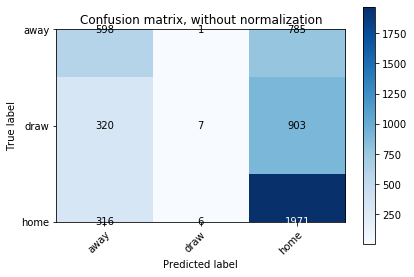


  When the winner prediction is the AWAY team, the probabilities are:
  	[GOOD] 48% that the winner is truly the away team
  	[BAD]  26% that it's a draw
  	[BAD]  26% that the winner is the home team
  
  When the prediction is a DRAW, the probabilities are:
  	[BAD]  7% that the winner is the away team
  	[GOOD] 50% that it's truly a draw
  	[BAD]  43% that the winner is the home team
  
  When the winner prediction is the HOME team, the probabilities are:
  	[BAD]  21% that the winner is the away team
  	[BAD]  25% that it's a draw
  	[GOOD] 54% that the winner is truly the home team
  


In [0]:
y_pred = rf.predict(X_test_PCA)
print_confusion_matrix_explained(y_pred, y_test)

### SVM

In [0]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')
clf.fit(X_train_PCA, y_train)
print(clf.score(X_test_PCA,y_test))

0.5235378031383737


Confusion matrix, without normalization
[[ 536    0  848]
 [ 272    0  958]
 [ 260    0 2033]]


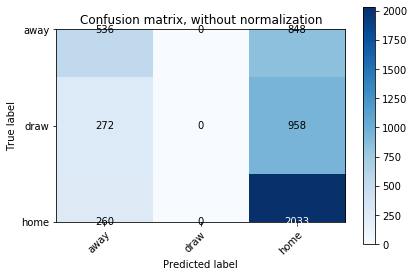


  When the winner prediction is the AWAY team, the probabilities are:
  	[GOOD] 50% that the winner is truly the away team
  	[BAD]  25% that it's a draw
  	[BAD]  24% that the winner is the home team
  
  There are no predicted matches where the result is a DRAW

  When the winner prediction is the HOME team, the probabilities are:
  	[BAD]  22% that the winner is the away team
  	[BAD]  25% that it's a draw
  	[GOOD] 53% that the winner is truly the home team
  


In [0]:
y_pred = clf.predict(X_test_PCA)
print_confusion_matrix_explained(y_pred, y_test)

### KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors = 260)
knn.fit(X_train_PCA, y_train)
print(knn.score(X_test_PCA, y_test))

0.5190544120643978


Confusion matrix, without normalization
[[ 561   20  803]
 [ 302   12  916]
 [ 304   15 1974]]


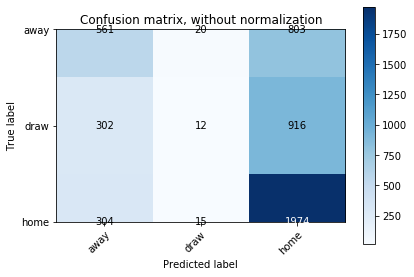


  When the winner prediction is the AWAY team, the probabilities are:
  	[GOOD] 48% that the winner is truly the away team
  	[BAD]  26% that it's a draw
  	[BAD]  26% that the winner is the home team
  
  When the prediction is a DRAW, the probabilities are:
  	[BAD]  43% that the winner is the away team
  	[GOOD] 26% that it's truly a draw
  	[BAD]  32% that the winner is the home team
  
  When the winner prediction is the HOME team, the probabilities are:
  	[BAD]  22% that the winner is the away team
  	[BAD]  25% that it's a draw
  	[GOOD] 53% that the winner is truly the home team
  


In [0]:
y_pred = knn.predict(X_test_PCA)
print_confusion_matrix_explained(y_pred, y_test)

The Random Forest, SVM and KNN models find the right prediction when the winner team is the away team or the home team. That happens in usually a bit more (sometimes a bit less) than 50% of the matches. <br><br>However, the SVM model never predicts draws and the Random Forest model looks better than the KNN model to detect draws. We can also observe that the Random Forest model will be less likely to consider a match to lead to a draw than the KNN model. 
<br><br>We observed that less matches predicted as draws means a better score. This observation happened when we realized that the SVM never predicts draws. We changed its "C parameter" that has a default value equal to 1 to bigger values and realized that the predictions made by the SVM model started to contain draws after this change. But it also made the score fall every time we changed the "C parameter" to a bigger value. Note changing this "C parameter" to higher values will lead to a smoother decision boundary.
We also observed the same effect on the Random Forest, the "max_depth parameter" act as the "C parameter" of SVM, whanever we increase the "max_depth", the score fall down.<br><br>Considering the scores of each of those 3 models and their stability in terms of the confusion matrix, we choosed to consider the Random Forest model to be the most adapted to the situation.

In [0]:
complete_training_data_PCA = pca.transform(X_prepared_training) # new data after PCA
best_model = RandomForestClassifier(max_depth=10, n_estimators=90)
best_model.fit(complete_training_data_PCA, np.ravel(labels))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Exporting predictions

In [0]:
import csv

#Loading and cleaning test_data with the same transformation done in training_set
test_data = clean_data(is_training_data = False,
                       nb_overall_ratings_to_drop = 11,
                       overall_ratings_meaned = OVERALL_RATINGS_MEANED, 
                       team_attributes_meaned = TEAM_ATTRIBUTES_MEANED
                       )
prepared_test_set = full_pipeline.transform(test_data)

#new data after PCA
test_set_after_PCA = pca.transform(prepared_test_set)

test_set_predictions = best_model.predict(test_set_after_PCA)

with open('resp_pred.csv', 'w') as writeFile:
  writer = csv.writer(writeFile)
  writer.writerow(['id', 'classes'])
  for i,preds in enumerate(test_set_predictions):
    writer.writerows([[i,preds]])

writeFile.close()
!cp resp_pred.csv drive/My\ Drive/

Data file named drive/My Drive/test_data_test.csv found
Data loaded in 0.9227268695831299 seconds
